In [ ]:
import pandas as pd
import numpy as np

from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import Normalizer
from sklearn.model_selection import StratifiedKFold

#classifiers
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier, StackingClassifier

#Prformance metrics
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline

from sklearn.exceptions import ConvergenceWarning
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

simplefilter(action='ignore', category=ConvergenceWarning)

simplefilter(action='ignore', category=UserWarning)

from statistics import mean

# Explainable AI
import shap

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize']=15,10

In [ ]:
def Algo_search(models , params, X_train, y_train, X_test, y_test):

    max_score = 0
    max_model = None
    max_model_params = None
    estimators_gridsearch = pd.DataFrame()
    models_est = []
    parametres = []
    lscore = []
    lroc = []
    lfscore = []
    lprecision = []
    lrecall = []
    
    scoring = {'accuracy': make_scorer(accuracy_score), 
               'roc_auc': make_scorer(roc_auc_score, needs_threshold=True),
               'f1': make_scorer(f1_score), 
               'precision': make_scorer(precision_score), 
               'recall': make_scorer(recall_score),}

    for i,j in zip(models.keys() , models.values() ):

        gs = GridSearchCV(estimator=j,param_grid=params[i], scoring=scoring, refit = "accuracy", )
        a = gs.fit(X_train,y_train)
        score = gs.score(X_test,y_test )
        mauc = []
        mprecision = []
        mrecall = []
        mfscore = []
        maccuracy = []
        for i in range(5):
          maccuracy.append(mean(gs.cv_results_['split'+str(i)+'_test_accuracy']))
          mauc.append(mean(gs.cv_results_['split'+str(i)+'_test_roc_auc']))
          mfscore.append(mean(gs.cv_results_['split'+str(i)+'_test_f1']))
          mprecision.append(mean(gs.cv_results_['split'+str(i)+'_test_precision']))
          mrecall.append(mean(gs.cv_results_['split'+str(i)+'_test_recall']))
        models_est.append(gs.best_estimator_)
        parametres.append(gs.best_params_)
        lscore.append(round(score,2))
        lroc.append(round(mean(mauc),2))
        lfscore.append(round(mean(mfscore),2))
        lprecision.append(round(mean(mprecision),2))
        lrecall.append(round(mean(mrecall),2))

        if score > max_score:
            max_score = score
            max_model = gs.best_estimator_
            max_model_params = gs.best_params_

    estimators_gridsearch['Models'] = list(models_est)
    estimators_gridsearch['Best parameters'] = list(parametres)
    estimators_gridsearch['Score'] = list(lscore)
    estimators_gridsearch['AUC'] = list(lroc)
    estimators_gridsearch['F1-score'] = list(lfscore)
    estimators_gridsearch['Precision'] = list(lprecision)
    estimators_gridsearch['Recall'] = list(lrecall)
   

    # print(estimators_gridsearch)

    return [max_score, max_model, max_model_params], estimators_gridsearch

In [ ]:
#Data points

models = {'model_gbm':GradientBoostingClassifier(), 'model_rf':RandomForestClassifier(), 
  'model_dt':DecisionTreeClassifier(), 'model_svm':SVC(), 'model_ada':AdaBoostClassifier(), 'model_knn': KNeighborsClassifier(), 
  'model_xgb': xgb.XGBClassifier(),'model_ext': ExtraTreesClassifier(), 'model_mlp': MLPClassifier()}
params_gbm = {'learning_rate':[0.1,0.2,0.3,0.4], 'n_estimators':[50,100,500,1000,2000]}
params_rf = {'n_estimators':[50,100,500,1000,2000], 'max_depth' : [5, 10, 20], 'class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]}
params_dt = {'splitter':['best','random'], 'max_depth':[1, 5, 10, 50, 100]}
params_svm = {'C':[1,2,5,10,50,100,500], 'kernel':['rbf','poly','sigmoid','linear']}
params_ada = {'n_estimators':[10,20,30,50,100,500,1000], 'learning_rate':[0.5,1,2,5,10]}
params_knn = {'n_neighbors' : [2,5,10,25,50]}
params_xgb = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}
params_ext = {'n_estimators':[50,100,500,1000,2000], 'max_depth' : [5, 10, 20], 'class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]}
model_mlp = {'solver': ['lbfgs', 'sgd', 'adam'], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 
             'learning_rate':['constant','adaptive'], 'alpha': [0.0001, 0.05],
             'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)]}
params = {'model_gbm':params_gbm, 'model_rf':params_rf, 'model_dt':params_dt, 'model_svm':params_svm, 'model_ada':params_ada, 'model_knn': params_knn,
          'model_xgb':params_xgb, 'model_ext':params_ext, 'model_mlp': model_mlp}

In [ ]:
mgh = pd.read_excel('mghML.xlsx')
icl = pd.read_excel('iclML.xlsx')
yps = pd.read_excel('ypsML.xlsx')

In [ ]:
common_columns = list(set(mgh) & set(icl) & set(yps))
mgh_c = mgh[common_columns]
icl_c = icl[common_columns]
yps_c = yps[common_columns]

In [ ]:
yps_c = yps_c.drop([124, 125, 126])
percent_missing = yps_c.isnull().sum() * 100 / len(yps_c)
missing_value_df = pd.DataFrame({'column_name': yps_c.columns,
                                 'percent_missing': percent_missing})
missing_value_df.loc[missing_value_df['percent_missing']> 0.000] 

,column_name,percent_missing
CD6,CD6,100.0


In [ ]:
mgh_con = mgh_c.drop('CD6', axis=1)
icl_con = icl_c.drop('CD6', axis=1)
yps_con = yps_c.drop('CD6', axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler

col = mgh_con.drop(['WHO max', 'KIDNEY', 'Age cat'], axis=1).columns

sc = StandardScaler()

for i in col:
    mgh_con[[i]] = sc.fit_transform(mgh_con[[i]])
    icl_con[[i]] = sc.fit_transform(icl_con[[i]])
    yps_con[[i]] = sc.fit_transform(yps_con[[i]])

# MGH dataset

In [ ]:
X = mgh_con.drop(['WHO max'], axis=1)
y = mgh_con['WHO max']

In [ ]:
X_test1 = icl_con.drop(['WHO max'], axis=1)
y_test1 = icl_con['WHO max']

In [ ]:
X_test2 = yps_con.drop(['WHO max'], axis=1)
y_test2 = yps_con['WHO max']

In [ ]:
pca = PCA(.90)
 

X = pca.fit_transform(X[col])
X = pd.DataFrame(X)
X['KIDNEY'] = list(mgh_con['KIDNEY'])
X['Age cat'] = list(mgh_con['Age cat'])

X_test1 = pca.transform(X_test1[col])
X_test1 = pd.DataFrame(X_test1)
X_test1['KIDNEY'] = list(icl_con['KIDNEY'])
X_test1['Age cat'] = list(icl_con['Age cat'])

X_test2 = pca.transform(X_test2[col])
X_test2 = pd.DataFrame(X_test2)
X_test2['KIDNEY'] = list(yps_con['KIDNEY'])
X_test2['Age cat'] = list(yps_con['Age cat'])
 
explained_variance = pca.explained_variance_ratio_

In [ ]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, index=mgh_con.drop(['WHO max'], axis=1)[col].columns)
loading_matrix

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
TNFRSF10A,0.797710,-0.204731,-0.234727,-0.115882,-0.061635,0.013233,-0.056326,-0.008419,0.150010,-0.037909,...,0.076022,0.036356,-0.095167,0.042071,0.003061,0.037474,-0.011173,0.013604,-0.024180,0.051163
CXCL1,0.253141,0.138941,0.044449,0.143732,-0.339333,-0.106429,0.207265,-0.130248,-0.402272,-0.122429,...,0.080746,0.040365,-0.014334,0.061180,-0.087790,-0.108023,-0.008110,0.003904,-0.057877,0.128499
ITM2A,0.633502,-0.350919,-0.048621,-0.102820,-0.030706,0.148995,0.122867,-0.088981,0.088043,0.058009,...,-0.008549,-0.069752,-0.167011,0.122260,0.086425,0.142849,0.107072,0.001171,-0.006032,-0.056704
SIT1,0.130831,0.179770,0.253993,0.248916,0.209400,0.472950,-0.289355,0.135301,-0.146441,0.347028,...,0.042623,-0.037030,0.006670,0.016537,0.010709,-0.067238,0.010842,-0.065685,-0.032939,0.026445
EGLN1,0.734180,0.196859,-0.257842,0.216777,0.225424,0.171290,-0.044748,0.174698,0.074217,0.167909,...,-0.040446,0.013609,0.026512,-0.009803,-0.006016,-0.023270,0.021470,0.033686,-0.026712,-0.023275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GLO1,0.381934,0.292640,-0.390845,0.591383,0.285192,-0.080550,0.045263,0.013389,-0.109860,-0.087573,...,0.004563,-0.005082,-0.019318,-0.022084,0.006968,0.027341,-0.007367,-0.016814,0.017348,-0.018840
PPP1R9B,0.385466,0.749914,0.283715,-0.232300,-0.138367,-0.053719,0.078377,-0.043379,0.053315,0.008124,...,0.004730,-0.020397,-0.024401,0.024605,-0.019153,0.008554,0.027525,0.017290,-0.000192,0.028478
TANK,0.362025,0.709495,0.150870,-0.030039,-0.001636,-0.064957,0.090942,0.061639,-0.027805,0.092919,...,-0.114584,0.027340,0.150913,0.116223,0.020587,-0.060132,-0.083657,0.016547,-0.100436,0.122788
ITGA11,-0.092685,-0.117027,0.391809,0.285527,-0.314618,0.171078,-0.037022,-0.231539,0.387119,0.082766,...,0.053248,-0.002439,0.146997,-0.031662,-0.003097,0.014115,0.106198,0.079781,0.032728,-0.037619


In [ ]:
load_trans = loading_matrix.T
magnitude = 0
loading_pow = {}
for i in load_trans.columns:
    magnitude = load_trans[i].pow(2).sum()
    loading_pow[i] = magnitude

pd.DataFrame.from_dict(loading_pow, orient='index').to_excel('loadingspowMGHtask2.xlsx')

## ICL

In [ ]:
grid_mX_pca, grid_ml_pca = Algo_search(models = models, params = params, X_train=X, y_train=y, X_test=X_test1, y_test=y_test1)

grid_ml_pca

,Models,Best parameters,Score,AUC,F1-score,Precision,Recall
0,([DecisionTreeRegressor(criterion='friedman_ms...,"{'learning_rate': 0.1, 'n_estimators': 100}",0.76,0.77,0.55,0.68,0.47
1,"(DecisionTreeClassifier(max_depth=20, max_feat...","{'class_weight': None, 'max_depth': 20, 'n_est...",0.80,0.77,0.40,0.69,0.28
2,DecisionTreeClassifier(max_depth=5),"{'max_depth': 5, 'splitter': 'best'}",0.67,0.55,0.47,0.49,0.45
3,SVC(C=1),"{'C': 1, 'kernel': 'rbf'}",0.78,0.81,0.61,0.67,0.58
4,"(DecisionTreeClassifier(max_depth=1, random_st...","{'learning_rate': 0.5, 'n_estimators': 20}",0.73,0.75,0.56,0.66,0.50
5,KNeighborsClassifier(n_neighbors=10),{'n_neighbors': 10},0.84,0.78,0.48,0.77,0.35
6,"(ExtraTreeClassifier(max_depth=20, random_stat...","{'class_weight': None, 'max_depth': 20, 'n_est...",0.71,0.79,0.36,0.73,0.24
7,"MLPClassifier(activation='tanh', solver='sgd')","{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.75,0.80,0.62,0.63,0.61
8,"XGBClassifier(max_depth=8, n_estimators=50, re...","{'gamma': 0, 'learning_rate': 0.1, 'max_depth'...",0.71,0.79,0.61,0.74,0.53


### Explainable AI

In [ ]:
clf = MLPClassifier(activation= 'tanh',
hidden_layer_sizes= (100,),
alpha= 0.0001,
learning_rate= 'constant',
solver= 'sgd'
)

clf.fit(X, y)

explainer = shap.KernelExplainer(clf.predict,X)
shap_values = explainer.shap_values(X_test1)

Using 305 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/55 [00:00<?, ?it/s]

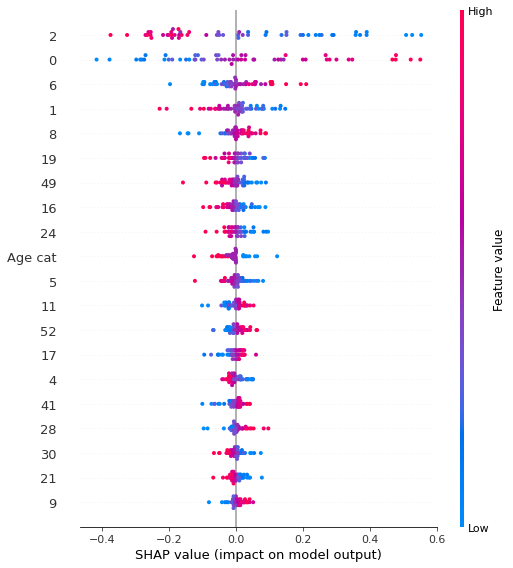

In [ ]:
import matplotlib.pyplot as plt
shap.summary_plot(shap_values,X_test1,feature_names=X.columns, max_display =20,show=False )
plt.savefig('mlp_xai_mgh_icl.svg')

In [ ]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.to_excel('mgh_mlp_icl_xai.xlsx')

In [ ]:
lp =  [i for i in list(feature_importance['col_name'])[:21] if str(i).isdigit()]

load_trans = loading_matrix[lp].T
magnitude = 0
loading_pow = {}
for i in load_trans.columns:
  magnitude = load_trans[i].pow(2).sum()
  loading_pow[i] = magnitude

pd.DataFrame.from_dict(loading_pow, orient='index').to_excel('loadingspowMGHtoICLmpl.xlsx')

## YPS

In [ ]:
grid_mX_pca, grid_ml_pca_yps = Algo_search(models = models, params = params, X_train=X, y_train=y, X_test=X_test2, y_test=y_test2)

grid_ml_pca_yps

,Models,Best parameters,Score,AUC,F1-score,Precision,Recall
0,([DecisionTreeRegressor(criterion='friedman_ms...,"{'learning_rate': 0.4, 'n_estimators': 100}",0.84,0.77,0.55,0.67,0.48
1,"(DecisionTreeClassifier(max_depth=20, max_feat...","{'class_weight': None, 'max_depth': 20, 'n_est...",0.85,0.77,0.42,0.72,0.30
2,"DecisionTreeClassifier(max_depth=1, splitter='...","{'max_depth': 1, 'splitter': 'random'}",0.84,0.58,0.32,0.63,0.23
3,SVC(C=1),"{'C': 1, 'kernel': 'rbf'}",0.85,0.81,0.61,0.67,0.58
4,"(DecisionTreeClassifier(max_depth=1, random_st...","{'learning_rate': 0.5, 'n_estimators': 20}",0.84,0.75,0.56,0.66,0.50
5,KNeighborsClassifier(n_neighbors=10),{'n_neighbors': 10},0.86,0.78,0.48,0.77,0.35
6,"(ExtraTreeClassifier(max_depth=20, random_stat...","{'class_weight': None, 'max_depth': 20, 'n_est...",0.83,0.80,0.40,0.76,0.28
7,"MLPClassifier(activation='tanh', hidden_layer_...","{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.82,0.81,0.62,0.65,0.60
8,"XGBClassifier(max_depth=8, n_estimators=50, re...","{'gamma': 0, 'learning_rate': 0.1, 'max_depth'...",0.86,0.79,0.61,0.74,0.53


### Explainable AI

In [ ]:
clf = MLPClassifier(activation= 'tanh',
hidden_layer_sizes= (50, 50, 50),
alpha= 0.0001,
learning_rate= 'adaptive',
solver= 'sgd'
)

clf.fit(X, y)

explainer = shap.KernelExplainer(clf.predict,X)
shap_values = explainer.shap_values(X_test2)

Using 305 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/256 [00:00<?, ?it/s]

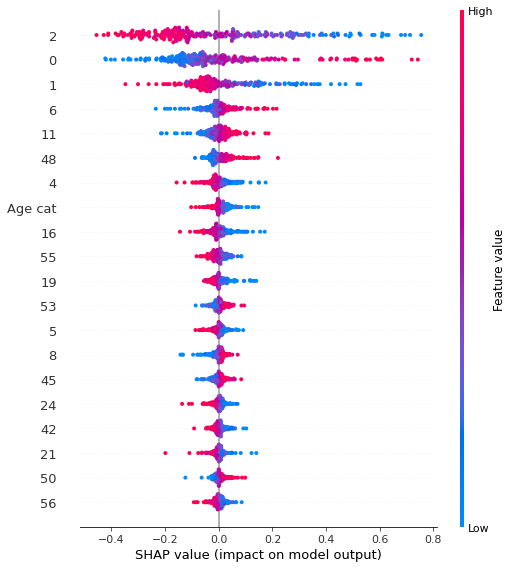

In [ ]:
import matplotlib.pyplot as plt
shap.summary_plot(shap_values,X_test2,feature_names=X.columns, max_display =20,show=False )
plt.savefig('mlp_xai_mgh_yps.svg')

In [ ]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.to_excel('mgh_mlp_yps_xai.xlsx')

In [ ]:
lp =  [i for i in list(feature_importance['col_name'])[:21] if str(i).isdigit()]

load_trans = loading_matrix[lp].T
magnitude = 0
loading_pow = {}
for i in load_trans.columns:
  magnitude = load_trans[i].pow(2).sum()
  loading_pow[i] = magnitude

pd.DataFrame.from_dict(loading_pow, orient='index').to_excel('loadingspowMGHtoYPSmpl.xlsx')

# YPS dataset

In [ ]:
X = yps_con.drop(['WHO max'], axis=1)
y = yps_con['WHO max']

In [ ]:
X_test1 = icl_con.drop(['WHO max'], axis=1)
y_test1 = icl_con['WHO max']

In [ ]:
X_test2 = mgh_con.drop(['WHO max'], axis=1)
y_test2 = mgh_con['WHO max']

In [ ]:
pca = PCA(.90)
 
X = pca.fit_transform(X[col])
X = pd.DataFrame(X)
X['KIDNEY'] = list(yps_con['KIDNEY'])
X['Age cat'] = list(yps_con['Age cat'])


X_test1 = pca.transform(X_test1[col])
X_test1 = pd.DataFrame(X_test1)
X_test1['KIDNEY'] = list(icl_con['KIDNEY'])
X_test1['Age cat'] = list(icl_con['Age cat'])


X_test2 = pca.transform(X_test2[col])
X_test2 = pd.DataFrame(X_test2)
X_test2['KIDNEY'] = list(mgh_con['KIDNEY'])
X_test2['Age cat'] = list(mgh_con['Age cat'])
 
explained_variance = pca.explained_variance_ratio_

In [ ]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, index=yps_con.drop(['WHO max'], axis=1)[col].columns)
loading_matrix

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
PADI2,0.185265,0.290259,0.096207,0.177796,0.060971,-0.132316,0.162581,0.032703,0.159832,0.148374,...,-0.015878,0.103218,0.014140,-0.085143,0.013206,0.168408,-0.037142,-0.069784,-0.008192,0.094283
TNF,0.664572,0.566817,0.099295,-0.058488,-0.033647,0.138605,-0.198789,0.037580,0.061956,-0.053142,...,-0.038470,-0.053540,-0.084142,-0.030940,0.056747,0.003489,-0.059054,-0.026892,-0.016471,-0.030832
NTF4,-0.299257,0.036657,-0.117001,0.276262,-0.197796,0.085638,-0.099776,-0.002739,0.269674,0.022818,...,-0.017002,-0.062447,0.073164,0.107295,0.060386,-0.139602,0.051448,0.068168,-0.008835,-0.075251
SH2D1A,-0.500462,0.256107,-0.039449,0.264996,-0.166362,0.077634,0.241581,-0.045299,-0.327944,0.130274,...,0.082902,0.045541,-0.032675,-0.017191,0.099906,-0.034097,-0.020038,-0.060043,0.023619,0.065753
TNFRSF9,0.388303,0.462019,-0.476707,0.323234,-0.076156,0.087476,-0.267976,-0.046952,-0.067336,-0.197087,...,-0.032266,0.015113,-0.005006,-0.026084,0.033368,0.094410,0.025215,-0.040964,-0.039637,0.090872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PGF,0.407320,0.632454,-0.130870,0.157479,0.155316,-0.198072,-0.012667,-0.026586,0.050156,-0.288868,...,0.026915,-0.041211,0.116871,-0.029310,0.048338,-0.032054,-0.044420,0.097505,-0.055912,-0.012641
FCRL3,0.021800,0.212162,-0.368506,0.232978,-0.245505,0.294919,-0.039214,-0.037851,-0.062067,0.026484,...,-0.045252,0.103538,0.029314,0.094755,-0.120752,0.034494,0.010170,-0.042781,-0.065560,-0.045369
VEGFA,0.127509,0.665666,0.264007,0.101151,0.036236,-0.143981,-0.197576,0.082658,0.043985,-0.031689,...,0.023745,0.069864,0.051979,-0.094880,0.060571,0.078159,-0.117521,0.164456,-0.018921,-0.002658
KRT19,0.601978,0.448903,0.444960,-0.077246,0.009860,-0.202920,0.128936,0.037780,-0.035462,0.019507,...,-0.025515,-0.003225,0.015843,0.012196,-0.046100,-0.089813,0.020325,0.001998,-0.010889,0.119265


In [ ]:
load_trans = loading_matrix.T
magnitude = 0
loading_pow = {}
for i in load_trans.columns:
  magnitude = load_trans[i].pow(2).sum()
  loading_pow[i] = magnitude

pd.DataFrame.from_dict(loading_pow, orient='index').to_excel('loadingspowYPStask2.xlsx')

## ICL

In [ ]:
grid_mX_pca, grid_ml_pca = Algo_search(models = models, params = params, X_train=X, y_train=y, X_test=X_test1, y_test=y_test1)

grid_ml_pca

,Models,Best parameters,Score,AUC,F1-score,Precision,Recall
0,([DecisionTreeRegressor(criterion='friedman_ms...,"{'learning_rate': 0.2, 'n_estimators': 50}",0.76,0.84,0.52,0.53,0.54
1,"(DecisionTreeClassifier(max_depth=20, max_feat...","{'class_weight': None, 'max_depth': 20, 'n_est...",0.76,0.84,0.22,0.55,0.14
2,DecisionTreeClassifier(max_depth=5),"{'max_depth': 5, 'splitter': 'best'}",0.69,0.71,0.53,0.51,0.62
3,SVC(C=5),"{'C': 5, 'kernel': 'rbf'}",0.78,0.94,0.67,0.78,0.68
4,"(DecisionTreeClassifier(max_depth=1, random_st...","{'learning_rate': 0.5, 'n_estimators': 50}",0.78,0.83,0.47,0.44,0.50
5,KNeighborsClassifier(n_neighbors=25),{'n_neighbors': 25},0.78,0.89,0.33,0.75,0.28
6,"(ExtraTreeClassifier(max_depth=10, random_stat...","{'class_weight': {0: 1, 1: 10}, 'max_depth': 1...",0.75,0.82,0.19,0.50,0.12
7,MLPClassifier(solver='sgd'),"{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.82,0.94,0.65,0.69,0.68
8,"XGBClassifier(gamma=0.1, learning_rate=0.7, ma...","{'gamma': 0.1, 'learning_rate': 0.7, 'max_dept...",0.80,0.86,0.57,0.76,0.50


### Explainable AI

In [ ]:
clf = MLPClassifier(activation= 'relu',
hidden_layer_sizes= (100,),
alpha= 0.0001,
learning_rate= 'constant',
solver= 'sgd'
)

clf.fit(X, y)

explainer = shap.KernelExplainer(clf.predict,X)
shap_values = explainer.shap_values(X_test1)

Using 256 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/55 [00:00<?, ?it/s]

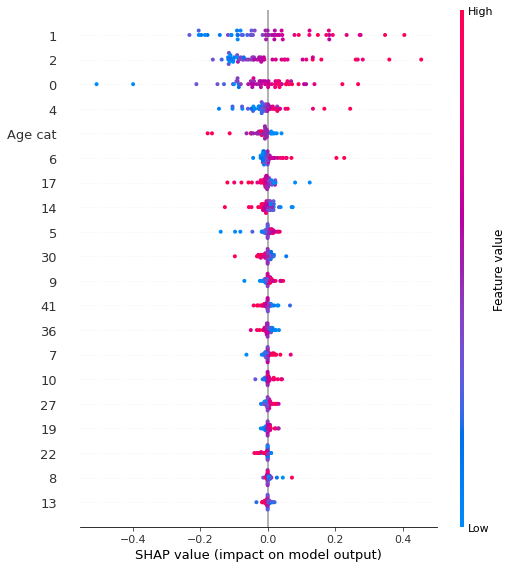

In [ ]:
import matplotlib.pyplot as plt
shap.summary_plot(shap_values,X_test1,feature_names=X.columns, max_display =20,show=False )
plt.savefig('mlp_xai_yps_icl.svg')

In [ ]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.to_excel('mgh_yps_icl_xai.xlsx')

In [ ]:
lp =  [i for i in list(feature_importance['col_name'])[:21] if str(i).isdigit()]

load_trans = loading_matrix[lp].T
magnitude = 0
loading_pow = {}
for i in load_trans.columns:
  magnitude = load_trans[i].pow(2).sum()
  loading_pow[i] = magnitude

pd.DataFrame.from_dict(loading_pow, orient='index').to_excel('loadingspowYPStoICLmpl.xlsx')

## MGH

In [ ]:
grid_mX_pca, grid_ml_pca = Algo_search(models = models, params = params, X_train=X, y_train=y, X_test=X_test2, y_test=y_test2)




grid_ml_pca

,Models,Best parameters,Score,AUC,F1-score,Precision,Recall
0,([DecisionTreeRegressor(criterion='friedman_ms...,"{'learning_rate': 0.2, 'n_estimators': 50}",0.67,0.85,0.51,0.53,0.52
1,"(DecisionTreeClassifier(max_depth=20, max_feat...","{'class_weight': None, 'max_depth': 20, 'n_est...",0.66,0.82,0.21,0.80,0.12
2,"DecisionTreeClassifier(max_depth=1, splitter='...","{'max_depth': 1, 'splitter': 'random'}",0.64,0.54,0.00,0.00,0.00
3,SVC(C=5),"{'C': 5, 'kernel': 'rbf'}",0.70,0.94,0.67,0.78,0.68
4,"(DecisionTreeClassifier(max_depth=1, random_st...","{'learning_rate': 0.5, 'n_estimators': 50}",0.69,0.83,0.47,0.44,0.50
5,KNeighborsClassifier(n_neighbors=25),{'n_neighbors': 25},0.65,0.89,0.33,0.75,0.28
6,"(ExtraTreeClassifier(max_depth=5, random_state...","{'class_weight': {0: 1, 1: 5}, 'max_depth': 5,...",0.70,0.87,0.42,0.51,0.42
7,"MLPClassifier(hidden_layer_sizes=(50, 50, 50),...","{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.71,0.86,0.60,0.62,0.70
8,"XGBClassifier(gamma=0.1, learning_rate=0.7, ma...","{'gamma': 0.1, 'learning_rate': 0.7, 'max_dept...",0.69,0.86,0.57,0.76,0.50


### Explainable AI

In [ ]:
clf = MLPClassifier(activation= 'relu',
hidden_layer_sizes= (50, 50, 50),
alpha= 0.0001,
learning_rate= 'adaptive',
solver= 'adam'
)

clf.fit(X, y)

explainer = shap.KernelExplainer(clf.predict,X)
shap_values = explainer.shap_values(X_test2)

Using 256 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/305 [00:00<?, ?it/s]

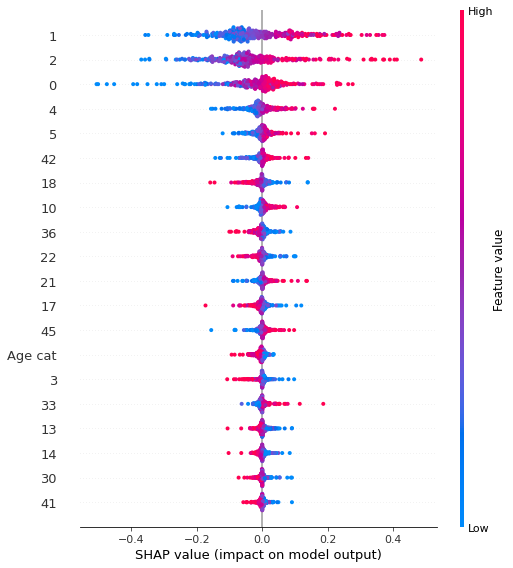

In [ ]:
import matplotlib.pyplot as plt
shap.summary_plot(shap_values,X_test2,feature_names=X.columns, max_display =20,show=False )
plt.savefig('mlp_xai_yps_mgh.svg')

In [ ]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.to_excel('mgh_yps_mgh_xai.xlsx')

In [ ]:
lp =  [i for i in list(feature_importance['col_name'])[:21] if str(i).isdigit()]

load_trans = loading_matrix[lp].T
magnitude = 0
loading_pow = {}
for i in load_trans.columns:
  magnitude = load_trans[i].pow(2).sum()
  loading_pow[i] = magnitude

pd.DataFrame.from_dict(loading_pow, orient='index').to_excel('loadingspowYPStoMGHmpl.xlsx')

# ICL dataset

In [ ]:
X = icl_con.drop(['WHO max'], axis=1)
y = icl_con['WHO max']

In [ ]:
X_test1 = yps_con.drop(['WHO max'], axis=1)
y_test1 = yps_con['WHO max']

In [ ]:
X_test2 = mgh_con.drop(['WHO max'], axis=1)
y_test2 = mgh_con['WHO max']

In [ ]:
pca = PCA(.90)
 
X = pca.fit_transform(X[col])
X = pd.DataFrame(X)
X['KIDNEY'] = list(icl_con['KIDNEY'])
X['Age cat'] = list(icl_con['Age cat'])

X_test1 = pca.transform(X_test1[col])
X_test1 = pd.DataFrame(X_test1)
X_test1['KIDNEY'] = list(yps_con['KIDNEY'])
X_test1['Age cat'] = list(yps_con['Age cat'])

X_test2 = pca.transform(X_test2[col])
X_test2 = pd.DataFrame(X_test2)
X_test2['KIDNEY'] = list(mgh_con['KIDNEY'])
X_test2['Age cat'] = list(mgh_con['Age cat'])
 
explained_variance = pca.explained_variance_ratio_

In [ ]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, index=icl_con.drop(['WHO max'], axis=1)[col].columns)
loading_matrix

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
PADI2,0.449112,-0.351198,0.372750,-0.080031,-0.022563,0.212563,-0.125401,0.167963,-0.006620,0.315036,...,0.149044,0.015410,-0.006099,-0.114161,0.065606,-0.044286,-0.017437,0.105818,-0.079829,0.074926
TNF,0.222402,-0.644291,-0.088030,0.166297,0.317129,-0.017309,0.034202,-0.109869,-0.321428,0.011333,...,0.076572,0.017154,0.230089,0.050087,-0.064315,0.083880,0.001578,0.034597,0.004371,-0.087636
NTF4,0.192649,-0.286860,-0.184748,-0.422365,-0.280658,-0.177679,0.140001,0.204948,-0.243305,-0.210081,...,0.202971,-0.020633,0.039845,-0.098247,-0.114510,-0.200051,-0.095271,0.042072,0.081888,-0.011702
SH2D1A,0.288056,-0.144189,-0.267626,0.125419,-0.130242,0.145341,0.355644,0.189862,-0.241801,-0.152290,...,-0.187571,-0.017491,-0.108204,-0.310805,-0.100792,-0.034822,0.022162,-0.177597,-0.012979,-0.042379
TNFRSF9,-0.027562,0.225177,-0.350171,0.629305,-0.180002,0.055368,-0.059731,-0.033287,-0.183046,0.128914,...,-0.044119,-0.003965,-0.061224,0.020185,-0.161343,0.116450,-0.050233,0.004984,0.027244,-0.002204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PGF,0.449012,-0.223170,-0.543811,-0.090254,-0.422730,0.271714,-0.077709,0.009349,-0.055924,0.021341,...,0.011338,-0.155276,0.072631,0.061127,0.070614,-0.094500,0.104132,-0.073430,0.026209,0.047733
FCRL3,-0.168464,-0.075079,0.048051,0.544284,0.164175,-0.208679,0.142044,0.137180,0.182361,0.011864,...,-0.194516,-0.184986,0.060718,-0.040108,-0.120731,-0.109990,0.020461,-0.000041,0.147353,0.029331
VEGFA,0.744103,-0.332496,-0.151798,-0.163632,-0.111182,0.119943,-0.007310,-0.150059,-0.025193,-0.031916,...,-0.118396,-0.011655,0.038851,-0.025670,0.034913,-0.000988,-0.033778,0.012884,-0.100690,0.058078
KRT19,0.443195,-0.641168,0.253166,-0.344109,0.120253,-0.035220,-0.020874,-0.133898,-0.116732,0.028670,...,-0.153926,0.014587,-0.004665,0.190300,-0.019797,-0.037615,0.049000,0.044832,0.042877,-0.035642


In [ ]:
load_trans = loading_matrix.T
magnitude = 0
loading_pow = {}
for i in load_trans.columns:
  magnitude = load_trans[i].pow(2).sum()
  loading_pow[i] = magnitude

pd.DataFrame.from_dict(loading_pow, orient='index').to_excel('loadingspowICLtask2.xlsx')

## YPS

In [ ]:
grid_mX_pca, grid_ml_pca = Algo_search(models = models, params = params, X_train=X, y_train=y, X_test=X_test1, y_test=y_test1)

grid_ml_pca

,Models,Best parameters,Score,AUC,F1-score,Precision,Recall
0,([DecisionTreeRegressor(criterion='friedman_ms...,"{'learning_rate': 0.4, 'n_estimators': 50}",0.79,0.26,0.07,0.05,0.10
1,"(DecisionTreeClassifier(max_depth=20, max_feat...","{'class_weight': {0: 1, 1: 5}, 'max_depth': 20...",0.81,0.63,0.13,0.20,0.10
2,"DecisionTreeClassifier(max_depth=1, splitter='...","{'max_depth': 1, 'splitter': 'random'}",0.80,0.50,0.13,0.20,0.10
3,"SVC(C=5, kernel='sigmoid')","{'C': 5, 'kernel': 'sigmoid'}",0.82,0.81,0.69,0.83,0.63
4,"(DecisionTreeClassifier(max_depth=1, random_st...","{'learning_rate': 0.5, 'n_estimators': 30}",0.78,0.51,0.20,0.20,0.20
5,KNeighborsClassifier(n_neighbors=10),{'n_neighbors': 10},0.81,0.82,0.00,0.00,0.00
6,"(ExtraTreeClassifier(max_depth=5, random_state...","{'class_weight': {0: 1, 1: 5}, 'max_depth': 5,...",0.81,0.50,0.13,0.20,0.10
7,"MLPClassifier(activation='logistic', hidden_la...","{'activation': 'logistic', 'alpha': 0.0001, 'h...",0.80,0.82,0.35,0.45,0.33
8,"XGBClassifier(gamma=1.6, max_depth=5, n_estima...","{'gamma': 1.6, 'learning_rate': 0.1, 'max_dept...",0.81,0.29,0.00,0.00,0.00


### Explainable AI

In [ ]:
clf = SVC(C=5,
          kernel="sigmoid"
)


clf.fit(X, y)

explainer = shap.KernelExplainer(clf.predict,X)
shap_values = explainer.shap_values(X_test1)

  0%|          | 0/256 [00:00<?, ?it/s]

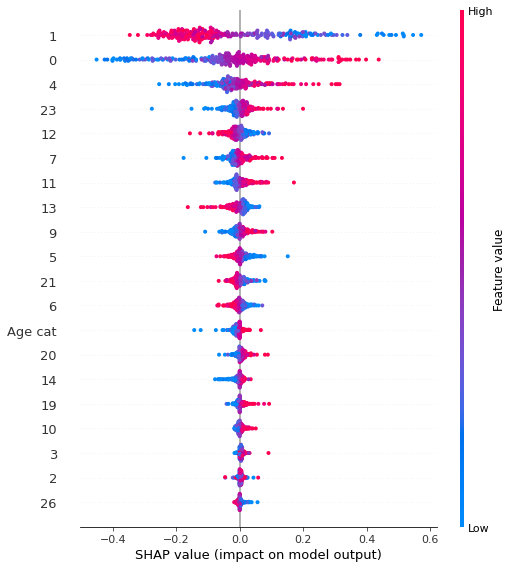

In [ ]:
import matplotlib.pyplot as plt
shap.summary_plot(shap_values,X_test1,feature_names=X.columns, max_display =20,show=False )
plt.savefig('mlp_xai_icl_yps.svg')

In [ ]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.to_excel('mgh_icl_yps_xai.xlsx')

In [ ]:
lp =  [i for i in list(feature_importance['col_name'])[:21] if str(i).isdigit()]

load_trans = loading_matrix[lp].T
magnitude = 0
loading_pow = {}
for i in load_trans.columns:
  magnitude = load_trans[i].pow(2).sum()
  loading_pow[i] = magnitude

pd.DataFrame.from_dict(loading_pow, orient='index').to_excel('loadingspowICLtoYPSmpl.xlsx')

## MGH

In [ ]:
grid_mX_pca, grid_ml_pca = Algo_search(models = models, params = params, X_train=X, y_train=y, X_test=X_test2, y_test=y_test2)

grid_ml_pca

,Models,Best parameters,Score,AUC,F1-score,Precision,Recall
0,([DecisionTreeRegressor(criterion='friedman_ms...,"{'learning_rate': 0.4, 'n_estimators': 500}",0.70,0.34,0.10,0.10,0.10
1,"(DecisionTreeClassifier(max_depth=5, max_featu...","{'class_weight': {0: 1, 1: 10}, 'max_depth': 5...",0.65,0.56,0.13,0.20,0.10
2,"DecisionTreeClassifier(max_depth=1, splitter='...","{'max_depth': 1, 'splitter': 'random'}",0.63,0.43,0.11,0.11,0.12
3,"SVC(C=5, kernel='sigmoid')","{'C': 5, 'kernel': 'sigmoid'}",0.73,0.81,0.69,0.83,0.63
4,"(DecisionTreeClassifier(max_depth=1, random_st...","{'learning_rate': 0.5, 'n_estimators': 30}",0.69,0.51,0.20,0.20,0.20
5,KNeighborsClassifier(n_neighbors=10),{'n_neighbors': 10},0.65,0.82,0.00,0.00,0.00
6,"(ExtraTreeClassifier(max_depth=5, random_state...","{'class_weight': {0: 1, 1: 5}, 'max_depth': 5,...",0.71,0.50,0.20,0.30,0.17
7,"MLPClassifier(activation='tanh', hidden_layer_...","{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.74,0.88,0.33,0.40,0.30
8,"XGBClassifier(max_depth=5, n_estimators=50, re...","{'gamma': 0, 'learning_rate': 0.1, 'max_depth'...",0.66,0.33,0.00,0.00,0.00


### Explainable AI

In [ ]:
clf = SVC(C=5,
          kernel="sigmoid"
)

clf.fit(X, y)

explainer = shap.KernelExplainer(clf.predict,X)
shap_values = explainer.shap_values(X_test2)

  0%|          | 0/305 [00:00<?, ?it/s]

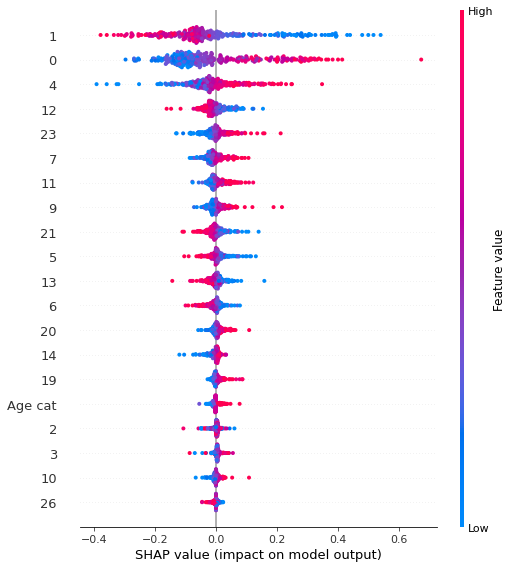

In [ ]:
import matplotlib.pyplot as plt
shap.summary_plot(shap_values,X_test2,feature_names=X.columns, max_display =20,show=False )
plt.savefig('mlp_xai_icl_mgh.svg')

In [ ]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.to_excel('mgh_icl_mgh_xai.xlsx')

In [ ]:
lp =  [i for i in list(feature_importance['col_name'])[:21] if str(i).isdigit()]

load_trans = loading_matrix[lp].T
magnitude = 0
loading_pow = {}
for i in load_trans.columns:
  magnitude = load_trans[i].pow(2).sum()
  loading_pow[i] = magnitude

pd.DataFrame.from_dict(loading_pow, orient='index').to_excel('loadingspowICLtoMGHmpl.xlsx')